# Volatility Model

In [44]:
from arch import arch_model
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import adfuller

In [45]:
# import data
df_train = pd.read_csv('../data/processed/SPY_Close_modeling_2.5y.csv')
df_train.tail()

,Date,close,log_return
618,2025-06-24,6092.18,0.011060
619,2025-06-25,6092.16,-0.000003
620,2025-06-26,6141.02,0.007988
621,2025-06-27,6173.07,0.005205
622,2025-06-30,6204.95,0.005151


In [46]:
df_test = pd.read_csv('../data/processed/SPY_Close_forecast_0.5y.csv')
df_test.head()

,Date,close,log_return
0,2025-07-01,6198.01,-0.001119
1,2025-07-02,6227.42,0.004734
2,2025-07-03,6279.35,0.008304
3,2025-07-07,6229.98,-0.007893
4,2025-07-08,6225.52,-0.000716


In [47]:
df_train = df_train.sort_values("Date").set_index("Date")
df_train.head()

,close,log_return
Date,,
2023-01-04,3852.97,0.007511
2023-01-05,3808.10,-0.011714
2023-01-06,3895.08,0.022584
2023-01-09,3892.09,-0.000768
2023-01-10,3919.25,0.006954


In [48]:
df_test = df_test.sort_values("Date").set_index("Date")
df_test.head()

,close,log_return
Date,,
2025-07-01,6198.01,-0.001119
2025-07-02,6227.42,0.004734
2025-07-03,6279.35,0.008304
2025-07-07,6229.98,-0.007893
2025-07-08,6225.52,-0.000716


### GARCH Modeling

In [49]:
# AR(0) mean model
y = df_train["log_return"].dropna()
mu = y.mean()
resid = y - mu

In [ ]:
from arch import arch_model
import pandas as pd

# ------------------------------------------------------------
# Prepare residuals (already demeaned)
# ------------------------------------------------------------
resid_pct = 100 * resid

models = []

# ------------------------------------------------------------
# Define model configurations
# ------------------------------------------------------------
model_specs = [
    ("GARCH(1,1)-t", dict(vol="GARCH", p=1, q=1, dist="t")),
    ("GARCH(1,2)-t", dict(vol="GARCH", p=1, q=2, dist="t")),
    ("GARCH(2,1)-t", dict(vol="GARCH", p=2, q=1, dist="t")),
    ("EGARCH(1,1)-t", dict(vol="EGARCH", p=1, q=1, dist="t")),
    ("GJR(1,1)-t", dict(vol="GARCH", p=1, o=1, q=1, dist="t")),
]

# ------------------------------------------------------------
# Fit all models and collect information criteria
# ------------------------------------------------------------
for name, spec in model_specs:
    try:
        am = arch_model(
            resid_pct,
            mean="Zero",
            vol=spec["vol"],
            p=spec.get("p", 1),
            o=spec.get("o", 0),
            q=spec.get("q", 1),
            dist=spec["dist"]
        )
        
        fit = am.fit(disp="off")
        
        models.append({
            "Model": name,
            "AIC": fit.aic,
            "BIC": fit.bic,
            "LogLik": fit.loglikelihood
        })
        
    except:
        continue

# ------------------------------------------------------------
# Create comparison table
# ------------------------------------------------------------
comparison_df = pd.DataFrame(models).sort_values("BIC", ).reset_index(drop=True)

print("\n" + "="*60)
print("Model Comparison")
print("="*60)
print(comparison_df)



Model Comparison
           Model          AIC          BIC      LogLik
0     GJR(1,1)-t  1557.797586  1579.970319 -773.898793
1   GARCH(1,1)-t  1586.664827  1604.403013 -789.332414
2  EGARCH(1,1)-t  1588.828814  1606.567000 -790.414407
3   GARCH(2,1)-t  1587.822055  1609.994787 -788.911027
4   GARCH(1,2)-t  1589.019007  1611.191740 -789.509504

Best GARCH model based on BIC: GJR(1,1)-t


In [51]:
# GJR(1,1)-t is the best model based on BIC
best_model_info = comparison_df.iloc[0]

best_model_name = best_model_info["Model"]
best_model_bic = best_model_info["BIC"]

print("\nBest Volatility Model based on BIC:")
print("Model:", best_model_name)
print("BIC:", best_model_bic)

best_spec = None
for name, spec in model_specs:
    if name == best_model_name:
        best_spec = spec
        break

best_am = arch_model(
    resid_pct,
    mean="Zero",
    vol=best_spec["vol"],
    p=best_spec.get("p", 1),
    o=best_spec.get("o", 0),
    q=best_spec.get("q", 1),
    dist=best_spec["dist"]
)

best_fit = best_am.fit(disp="off")

print("\nBest Model Full Summary:")
print(best_fit.summary())



Best Volatility Model based on BIC:
Model: GJR(1,1)-t
BIC: 1579.9703187087125

Best Model Full Summary:
                        Zero Mean - GJR-GARCH Model Results                         
Dep. Variable:                   log_return   R-squared:                       0.000
Mean Model:                       Zero Mean   Adj. R-squared:                  0.002
Vol Model:                        GJR-GARCH   Log-Likelihood:               -773.899
Distribution:      Standardized Student's t   AIC:                           1557.80
Method:                  Maximum Likelihood   BIC:                           1579.97
                                              No. Observations:                  623
Date:                      Sat, Feb 14 2026   Df Residuals:                      623
Time:                              12:41:08   Df Model:                            0
                              Volatility Model                             
                 coef    std err          t      P>|t|

In [52]:
garch11_t = arch_model(
    resid_pct,
    mean="Zero",
    vol="GARCH",
    p=1, q=1,
    dist="t"
).fit(disp="off")

print(garch11_t.summary())

                          Zero Mean - GARCH Model Results                           
Dep. Variable:                   log_return   R-squared:                       0.000
Mean Model:                       Zero Mean   Adj. R-squared:                  0.002
Vol Model:                            GARCH   Log-Likelihood:               -789.332
Distribution:      Standardized Student's t   AIC:                           1586.66
Method:                  Maximum Likelihood   BIC:                           1604.40
                                              No. Observations:                  623
Date:                      Sat, Feb 14 2026   Df Residuals:                      623
Time:                              12:41:08   Df Model:                            0
                             Volatility Model                             
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega     

In [53]:
from statsmodels.stats.diagnostic import het_arch

# ------------------------------------------------------------
# ARCH-LM for GARCH(1,1)-t
# ------------------------------------------------------------
std_garch = garch11_t.std_resid.dropna()
lm_stat, lm_pvalue, f_stat, f_pvalue = het_arch(std_garch, nlags=10)

print("\n" + "="*60)
print("ARCH-LM Test: GARCH(1,1)-t")
print("="*60)
print(f"Lags Used     : 10")
print(f"LM Statistic  : {lm_stat:.4f}")
print(f"LM p-value    : {lm_pvalue:.6f}")
print(f"F Statistic   : {f_stat:.4f}")
print(f"F p-value     : {f_pvalue:.6f}")


# ------------------------------------------------------------
# ARCH-LM for GJR(1,1)-t
# ------------------------------------------------------------
std_gjr = best_fit.std_resid.dropna() 
lm_stat, lm_pvalue, f_stat, f_pvalue = het_arch(std_gjr, nlags=10)

print("\n" + "="*60)
print("ARCH-LM Test: GJR(1,1)-t")
print("="*60)
print(f"Lags Used     : 10")
print(f"LM Statistic  : {lm_stat:.4f}")
print(f"LM p-value    : {lm_pvalue:.6f}")
print(f"F Statistic   : {f_stat:.4f}")
print(f"F p-value     : {f_pvalue:.6f}")



ARCH-LM Test: GARCH(1,1)-t
Lags Used     : 10
LM Statistic  : 27.7712
LM p-value    : 0.001964
F Statistic   : 2.8567
F p-value     : 0.001743

ARCH-LM Test: GJR(1,1)-t
Lags Used     : 10
LM Statistic  : 8.6140
LM p-value    : 0.569089
F Statistic   : 0.8580
F p-value     : 0.572774


In [54]:
# Ljung-Box test on squared standardized residuals
from statsmodels.stats.diagnostic import acorr_ljungbox

# --- Diagnostics for GARCH(1,1)-t ---
lb_garch_sq = acorr_ljungbox(std_garch**2, lags=[10, 20], return_df=True)

print("\n" + "="*60)
print("GARCH(1,1)-t: Ljung-Box on squared standardized residuals")
print("="*60)
print(lb_garch_sq)

# --- Diagnostics for GJR(1,1)-t ---  
lb_gjr_sq = acorr_ljungbox(std_gjr**2, lags=[10, 20], return_df=True)

print("\n" + "="*60)
print("GJR(1,1)-t: Ljung-Box on squared standardized residuals")
print("="*60)
print(lb_gjr_sq)


GARCH(1,1)-t: Ljung-Box on squared standardized residuals
      lb_stat  lb_pvalue
10  29.600224   0.000996
20  33.572698   0.029165

GJR(1,1)-t: Ljung-Box on squared standardized residuals
      lb_stat  lb_pvalue
10   9.698349   0.467345
20  14.520835   0.803138


In [55]:
# get returns for train and test sets
train_ret = df_train["log_return"].dropna()
test_ret  = df_test["log_return"].dropna()

train_ret.head()
test_ret.head()

Date
2025-07-01   -0.001119
2025-07-02    0.004734
2025-07-03    0.008304
2025-07-07   -0.007893
2025-07-08   -0.000716
Name: log_return, dtype: float64

From Ljung-Box test, GJR-GARCH(1,1) successfully capture 

### EWMA Modeling

In [56]:
# resid: demeaned returns (AR(0) residuals)
lambda_ = 0.94

train_returns_pct = 100 * train_ret
test_returns_pct = 100 * test_ret

# Initial variance from training sample
sigma2 = np.var(train_returns_pct)

ewma_forecasts = []

for r in test_returns_pct:
    
    # Update variance using previous observation
    sigma2 = lambda_ * sigma2 + (1 - lambda_) * r**2
    
    ewma_forecasts.append(sigma2)

ewma_forecasts = np.array(ewma_forecasts)

In [57]:
realized_variance = test_returns_pct.values**2

# MSE
ewma_mse = np.mean((ewma_forecasts - realized_variance)**2)

# QLIKE
ewma_qlike = np.mean(
    np.log(ewma_forecasts) +
    realized_variance / ewma_forecasts
)

print("EWMA MSE:", ewma_mse)
print("EWMA QLIKE:", ewma_qlike)

EWMA MSE: 0.7311456421972939
EWMA QLIKE: 0.12937239674206413


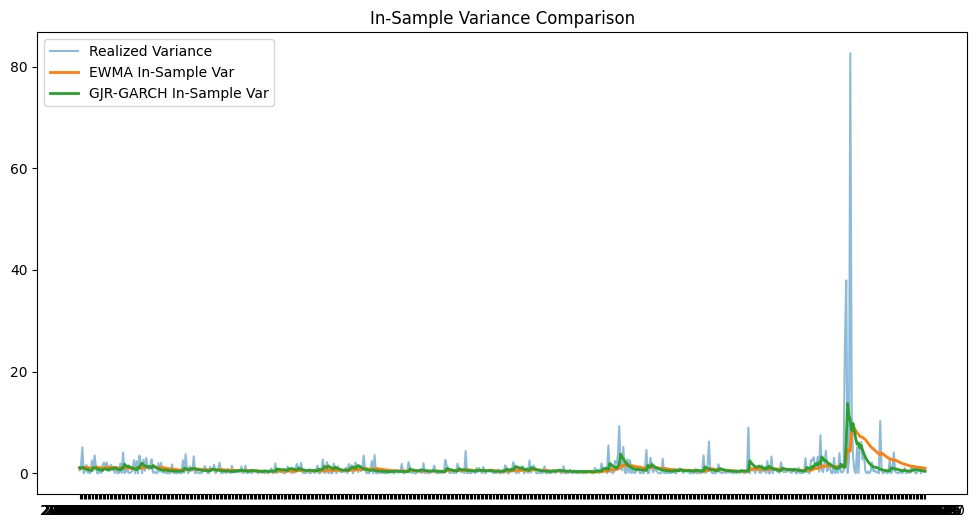

In [ ]:
#   in-sample variance comparison
in_sample_variance = best_fit.conditional_volatility**2
realized_variance = train_returns_pct.values**2
lambda_ = 0.94
returns = train_ret_pct.values
gjr_vol_in = best_fit.conditional_volatility
gjr_var_in = gjr_vol_in**2
ewma_var_in = np.zeros(len(returns))

# Initialize with sample variance
ewma_var_in[0] = np.var(returns)

# Recursive EWMA
for t in range(1, len(returns)):
    ewma_var_in[t] = (
        lambda_ * ewma_var_in[t-1] +
        (1 - lambda_) * returns[t-1]**2
    )
plt.figure(figsize=(12,6))

plt.plot(realized_variance, label="Realized Variance", alpha=0.5)
plt.plot(ewma_var_in, label="EWMA In-Sample Var", linewidth=2)
plt.plot(gjr_var_in, label="GJR-GARCH In-Sample Var", linewidth=2)

plt.title("In-Sample Variance Comparison")
plt.legend()
plt.show()

### GJR Forecasting

In [58]:
# Scale returns (recommended for stability)
train_ret_pct = 100 * train_ret
test_ret_pct  = 100 * test_ret

# Store forecasts
rolling_var_forecasts = []

In [ ]:
# ------------------------------------------------------------
# Step 2: Expanding-window rolling 1-step-ahead forecasts
# ------------------------------------------------------------

for i in range(len(test_ret_pct)):
    # Combine training data with test data observed up to time i-1
    rolling_data = np.concatenate([train_ret_pct.values, test_ret_pct.values[:i]])

    # Fit GJR-GARCH(1,1) with Student-t innovations
    model = arch_model(
        rolling_data,
        mean="Zero",
        vol="GARCH",
        p=1, o=1, q=1,
        dist="t"
    )

    fit = model.fit(disp="off")

    # 1-step ahead forecast of conditional variance
    f = fit.forecast(horizon=1, reindex=False)
    var_1step = f.variance.values[-1, 0]

    rolling_var_forecasts.append(var_1step)

rolling_var_forecasts = np.array(rolling_var_forecasts)

print("Rolling forecasts length:", len(rolling_var_forecasts))
print("First 5 variance forecasts:", rolling_var_forecasts[:5])

Rolling forecasts length: 128
First 5 variance forecasts: [0.41501988 0.39885873 0.38347289 0.37372743 0.50812063]


In [62]:
gjr_mse = np.mean((rolling_var_forecasts - realized_var)**2)
print("Rolling GJR-GARCH Variance MSE:", gjr_mse)
gjr_qlike = np.mean(
    np.log(rolling_var_forecasts) +
    realized_var / rolling_var_forecasts
)

print("Rolling GJR-GARCH QLIKE:", gjr_qlike)

Rolling GJR-GARCH Variance MSE: 0.8038464385008564
Rolling GJR-GARCH QLIKE: 0.24390275009341156


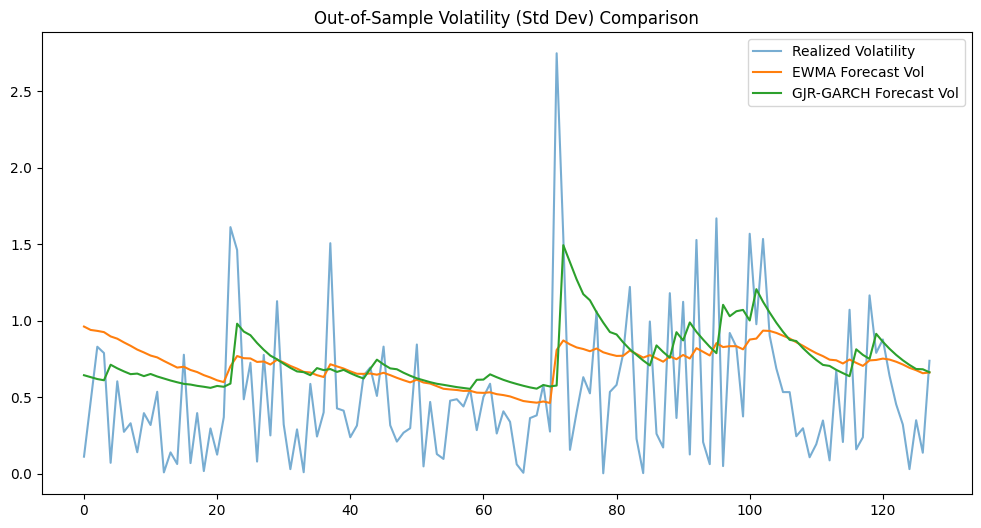

In [63]:
plt.figure(figsize=(12,6))

plt.plot(np.sqrt(realized_var), label="Realized Volatility", alpha=0.6)
plt.plot(np.sqrt(ewma_forecasts), label="EWMA Forecast Vol")
plt.plot(np.sqrt(rolling_var_forecasts), label="GJR-GARCH Forecast Vol")

plt.title("Out-of-Sample Volatility (Std Dev) Comparison")
plt.legend()
plt.show()